In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

In [2]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

# -------------------- Make empyty dataframes w/ right cols to fill with data

rn_samp = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/170313_2018.pkl')
ambe_samp = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/170316_0834.pkl')

rn = pd.DataFrame(columns = list(rn_samp))
ambe = pd.DataFrame(columns = list(ambe_samp))

# ------------------- Import it ALL into one dataframe

for filename in os.listdir('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/' + str(filename))
    rn = rn.append(df)

for filename in os.listdir('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/' + str(filename))
    ambe = ambe.append(df)
    
ambe = ambe[ambe.s2>200]

## define functions for quicker graphing

In [3]:
def slicing(df, x_feat, y_feat, bins):
    """Designed to slice in a 2-d space, fit gauss to those slices, and return a binned dataframe"""
    bin_mids = []
    
    sigmas = []
    means = []

    for i in range(1, len(bins)):
        a = df.loc[(df[x_feat] < bins[i]) & (df[x_feat] > bins[i-1])]

        mn = np.mean(a[y_feat])
        sg = np.std(a[y_feat])
        bm = np.mean(a[x_feat])

        if (np.logical_not(np.isnan(mn)) & np.logical_not(np.isnan(sg))):
            means.append(mn)
            sigmas.append(sg)
            bin_mids.append(bm)

    return pd.DataFrame(np.array([bin_mids, means, sigmas]).T, index = range(len(means)), columns = [x_feat,y_feat,'sigma'])

In [4]:
def plot2d_compare(x, y,xlim=None, ylim=None):
    plt.figure(figsize=(8,6))
    plt.scatter(ambe[x], ambe[y], color='r', label='ambe', s=0.2)
    
    plt.scatter(sim[x], sim[y], color='b', label='sim', s=0.2)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.xlabel(x)
    plt.ylabel(y)
    
    plt.legend(loc='upper left')

In [5]:
def line_cut(df, values, less_greater, value):
    if less_greater in ("less","<","less than"):
        return df[df[values] < value]
    elif less_greater in ("greater",">","greater than"):
        return df[df[values] > value]

In [6]:
# ------------------- The linear cut used in s2 - other largest s2 space for SS

def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

In [7]:
def four_hist_compare(df_1, df_2, slice_in_x, y, plot_ranges):
    """Will take in two dataframes and plot their histograms in y atop eachother in the 4 ranges of slice_in_x
    specified by plot_ranges"""
    fig = plt.figure(figsize=(10,7))
    # ----------------------------------------
    ax = fig.add_subplot(221)

    slice_df_1 = df_1[(df_1[slice_in_x] > plot_ranges[0][0]) & (df_1[slice_in_x] < plot_ranges[0][1])]
    slice_df_2 = df_2[(df_2[slice_in_x] > plot_ranges[0][0]) & (df_2[slice_in_x] < plot_ranges[0][1])]

    ax.hist(slice_df_1[y].dropna(), bins=50, color='b', alpha=1, label='sim', normed=1)
    ax.hist(slice_df_2[y].dropna(), bins=50, color='r', alpha=0.5, label='ambe', normed=1)

    ax.set_title( "%s to %s, %s" % (plot_ranges[0][0], plot_ranges[0][1], slice_in_x))


    # ----------------------------------------
    ax = fig.add_subplot(222)

    slice_df_1 = df_1[(df_1[slice_in_x] > plot_ranges[1][0]) & (df_1[slice_in_x] < plot_ranges[1][1])]
    slice_df_2 = df_2[(df_2[slice_in_x] > plot_ranges[1][0]) & (df_2[slice_in_x] < plot_ranges[1][1])]

    ax.hist(slice_df_1[y].dropna(), bins=40, color='b', alpha=1, label='sim', normed=1)
    ax.hist(slice_df_2[y].dropna(), bins=40, color='r', alpha=0.5,  label='ambe', normed=1)

    ax.set_title( "%s to %s, %s" % (plot_ranges[1][0], plot_ranges[1][1], slice_in_x))

    ax.legend(loc = 'upper right')

    # ----------------------------------------
    ax = fig.add_subplot(223)

    slice_df_1 = df_1[(df_1[slice_in_x] > plot_ranges[2][0]) & (df_1[slice_in_x] < plot_ranges[2][1])]
    slice_df_2 = df_2[(df_2[slice_in_x] > plot_ranges[2][0]) & (df_2[slice_in_x] < plot_ranges[2][1])]

    ax.hist(slice_df_1[y].dropna(), bins=25, color='b', alpha=1, label='sim', normed=1)
    ax.hist(slice_df_2[y].dropna(), bins=25, color='r', alpha=0.5,  label='ambe', normed=1)

    ax.set_title( "%s to %s, %s" % (plot_ranges[2][0], plot_ranges[2][1], slice_in_x))
    ax.set_xlabel(y)

    # ----------------------------------------
    ax = fig.add_subplot(224)

    slice_df_1 = df_1[(df_1[slice_in_x] > plot_ranges[3][0]) & (df_1[slice_in_x] < plot_ranges[3][1])]
    slice_df_2 = df_2[(df_2[slice_in_x] > plot_ranges[3][0]) & (df_2[slice_in_x] < plot_ranges[3][1])]

    ax.hist(slice_df_1[y].dropna(), bins=35, color='b', alpha=1, label='sim', normed=1)
    ax.hist(slice_df_2[y].dropna(), bins=35, color='r', alpha=0.5, label='ambe', normed=1)

    ax.set_title( "%s to %s, %s" % (plot_ranges[3][0], plot_ranges[3][1], slice_in_x))
    ax.set_xlabel(y)

In [8]:
# Load in sim data
import hax

# using modified version of Tianyu's OtherLargeS2s peak extractor
from make_minitree import Peaks

hax.init(experiment='XENON1T',
         use_runs_db=False,
         pax_version_policy='loose',
         main_data_paths=['/home/shawaf/data/mc_ambe_quick/'],
         minitree_paths = ['/home/shawaf/data/mc_ambe_quick/'])

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


In [14]:
sim = hax.minitrees.load("mc_ambe_quick",[Peaks])
sim = sim[sim.s2>200]

DEBUG:hax.minitrees] Found minitree at /home/shawaf/data/mc_ambe_quick/mc_ambe_quick_Peaks.root
DEBUG:hax.minitrees] Found minitree at /home/shawaf/data/mc_ambe_quick/mc_ambe_quick_Peaks.root
DEBUG:hax.minitrees] Removing weird index column


In [10]:
# need some more quantities of the data
sim['r'] = np.sqrt(sim.x**2 + sim.y**2)
ambe['r'] = np.sqrt(ambe.x**2 + ambe.y**2)

sim['s2_1_r'] = np.sqrt(sim.s2_1_x**2 + sim.s2_1_y**2)
ambe['s2_1_r'] = np.sqrt(ambe.s2_1_x**2 + ambe.s2_1_y**2)

In [11]:
sim

,cs1,cs2,event_number,goodness_of_fit,run_number,s1,s2,s2_1_area,s2_1_delay_is1,s2_1_delay_is2,...,s2_5_x,s2_5_y,s2_5_z,s2_delay_is1,s2_range_50p_area,x,y,z,r,s2_1_r
1,82.279639,6230.118395,1,146.160995,0,95.556000,1518.759033,630.180237,5.434705e+05,-67279.500000,...,-28.202578,28.202578,-127.32624,610749.970215,2070.516739,40.735451,4.208343,-87.89904,40.952254,37.730424
2,13.222934,2557.842910,2,132.942444,0,16.494917,606.793701,29.317383,7.497228e+05,104509.875000,...,NaN,NaN,NaN,645212.947754,1582.229573,-21.387083,-40.604305,-92.69424,45.892450,45.396836
3,8.244783,2148.770714,3,195.381577,0,6.193325,1763.608765,77.064240,1.315474e+05,64499.984375,...,43.083935,-19.561787,-86.26752,67047.453613,743.936402,33.388512,23.793852,-9.39888,40.999269,36.396776
4,33.284614,2663.786430,4,182.467636,0,34.823128,1077.082031,836.745728,5.153756e+05,91837.156250,...,-47.404331,-5.400494,-119.06928,423538.437988,2766.158602,30.903957,-17.775776,-60.68448,35.651547,41.667488
5,41.948582,1787.454830,5,194.106552,0,34.419376,1332.034790,1316.632935,1.220681e+05,-10636.335938,...,1.800164,-38.763542,-25.60608,132704.395508,1355.560290,-8.582712,-39.364662,-18.76608,40.289447,43.240270
6,14.416057,2260.189450,6,309.398376,0,12.362331,1585.731689,605.730835,2.087897e+05,20213.812500,...,11.881085,-16.681524,-31.81392,188575.934570,1444.879298,18.069256,9.287728,-26.88480,20.316493,22.243831
7,94.921913,4975.350569,7,659.924866,0,74.760780,3768.957031,2749.371094,4.455918e+04,-63262.824219,...,29.162664,15.241392,-20.07216,107822.007324,1227.787278,38.308422,6.846275,-15.19776,38.915378,19.565100
8,8.708158,1768.668170,8,237.507843,0,9.018699,651.461487,28.807520,6.600467e+05,215213.375000,...,NaN,NaN,NaN,444833.338867,2351.410230,28.939877,25.937654,-63.77472,38.862300,23.834189
9,38.798372,3289.879671,9,170.746674,0,31.890713,2336.281006,607.079712,2.866730e+04,-120983.554688,...,-10.440954,37.323410,-39.58416,149650.856445,1375.788063,35.096832,11.437916,-21.33072,36.913596,27.428216
10,41.570121,4238.028923,10,179.735855,0,48.025501,1064.002563,98.383476,5.712120e+05,-25745.312500,...,26.762445,40.203674,-179.52048,596957.337402,1786.036846,38.098083,1.080243,-85.73472,38.113395,39.789019


Have all the data ready, now to go through the spaces and compare simulation to real data

# Area, width ---- s2 and largest other  s2

## Main s2

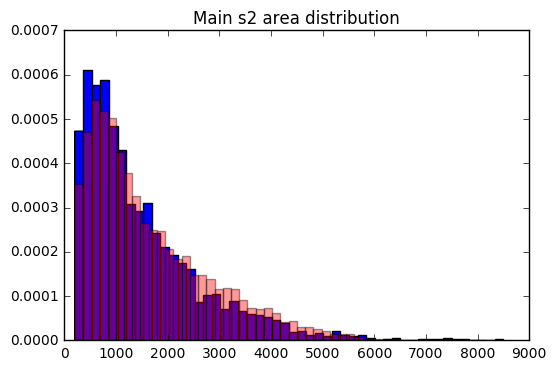

In [11]:
plt.hist(sim.s2.dropna(),bins=50, color='b',label='sim', normed=1)
plt.hist(ambe.s2, bins=50,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Main s2 area distribution')
plt.show()

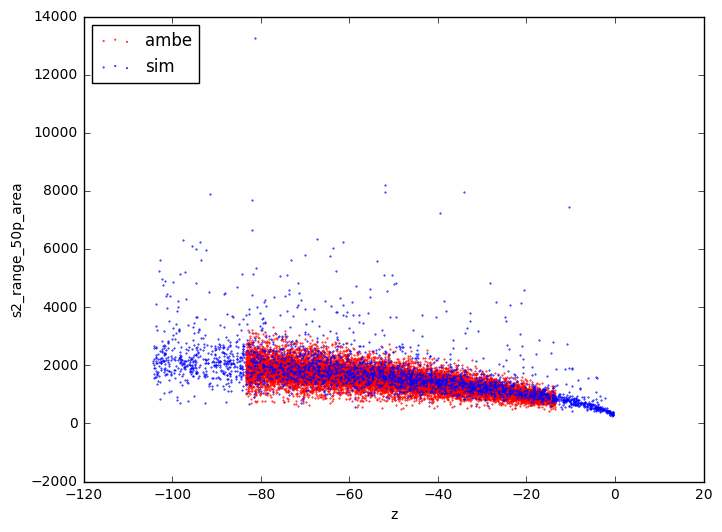

In [12]:
plot2d_compare('z','s2_range_50p_area')

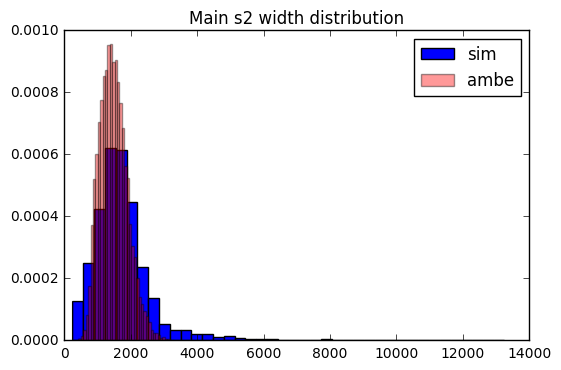

ambe mean: 1474.49975565
ambe std: 413.479791838
sim mean: 1736.18142406
sim std: 908.121551434


In [13]:
plt.hist(sim.s2_range_50p_area.dropna(),bins=40, color='b',label='sim', normed=1)
plt.hist(ambe.s2_range_50p_area.dropna(), bins=40,alpha=.4,color='r',label='ambe', normed=1)
plt.legend(loc='upper right')
plt.title('Main s2 width distribution')
plt.show()

print('ambe mean:' , np.mean(ambe.s2_range_50p_area.dropna()))
print('ambe std:' , np.std(ambe.s2_range_50p_area.dropna()))
print('sim mean:' , np.mean(sim.s2_range_50p_area.dropna()))
print('sim std:' , np.std(sim.s2_range_50p_area.dropna()))

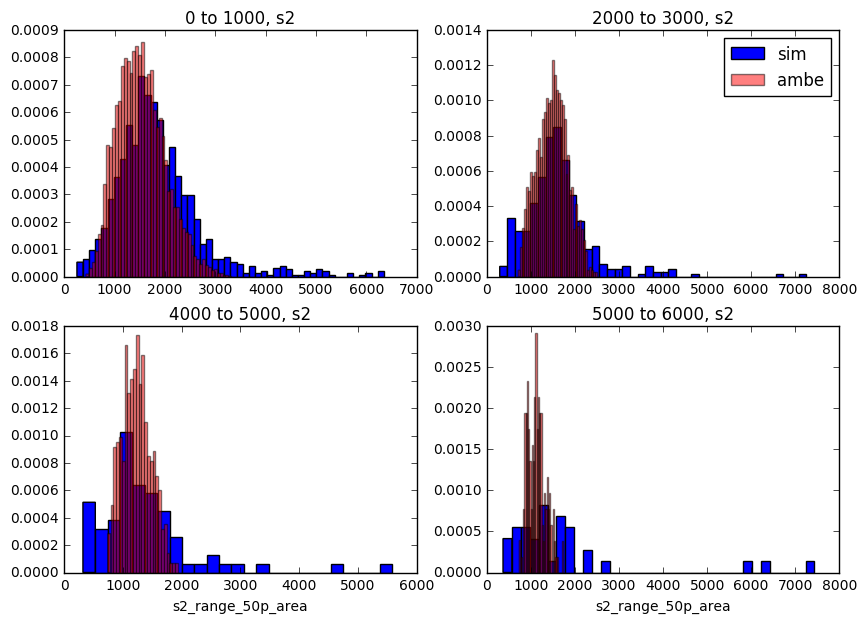

In [14]:
plt_ranges = [[0,1000],[2000,3000],[4000,5000],[5000,6000]]
four_hist_compare(sim, ambe, 's2', 's2_range_50p_area', plt_ranges)

In [15]:
ambe_bins = np.linspace(0,8000,30)
sim_bins = np.linspace(0,8000,28)
ambe_area_width = slicing(ambe, 's2', 's2_range_50p_area', ambe_bins)
sim_area_width = slicing(sim, 's2', 's2_range_50p_area', sim_bins)

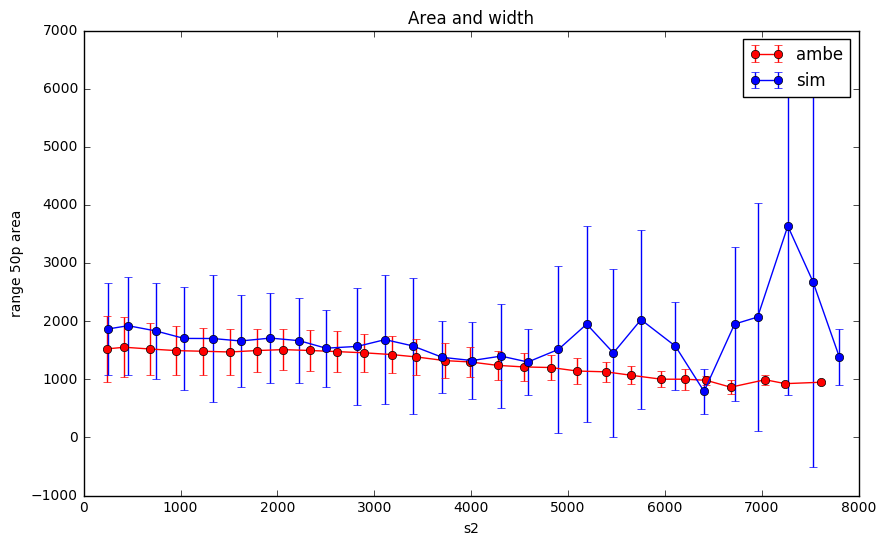

In [16]:
plt.figure(figsize = (10,6))
plt.errorbar(ambe_area_width.s2, ambe_area_width.s2_range_50p_area, ambe_area_width.sigma, color = 'r', marker='o', label='ambe')
plt.errorbar(sim_area_width.s2, sim_area_width.s2_range_50p_area, sim_area_width.sigma, color = 'b',marker='o', label = 'sim')
plt.title('Area and width')
plt.xlabel('s2')
plt.ylabel('range 50p area')
plt.legend(loc='upper right')
plt.show()

## Largest other s2

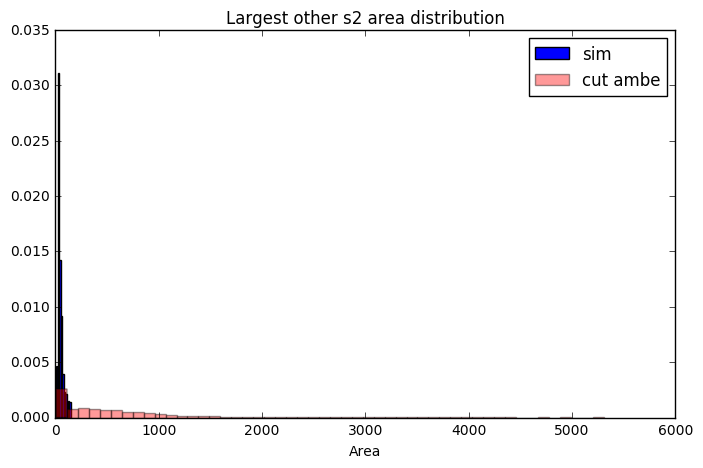

In [17]:
plt.figure(figsize=(8,5))
plt.hist(sim[sim.s2_1_area < 150].s2_1_area.dropna(),bins=10, color='b',label='sim', normed=1)
plt.hist(ambe.s2_1_area.dropna(), bins=50,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Largest other s2 area distribution')
plt.xlabel('Area')
plt.legend()
plt.show()

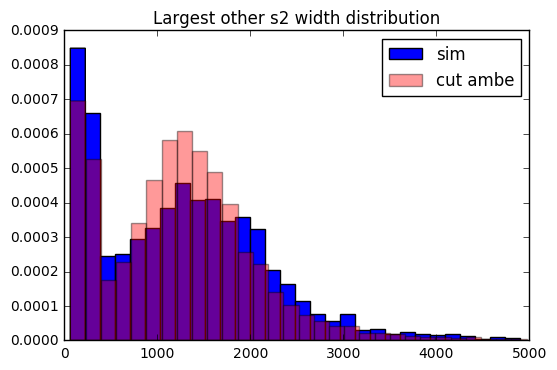

In [18]:
plt.hist(sim[sim.s2_1_range_50p_area < 5000].s2_1_range_50p_area.dropna(),bins=30, color='b',label='sim', normed=1)
plt.hist(ambe[ambe.s2_1_range_50p_area < 5000].s2_1_range_50p_area.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Largest other s2 width distribution')
plt.legend()
plt.show()

# r, z, time delays

## Main s2

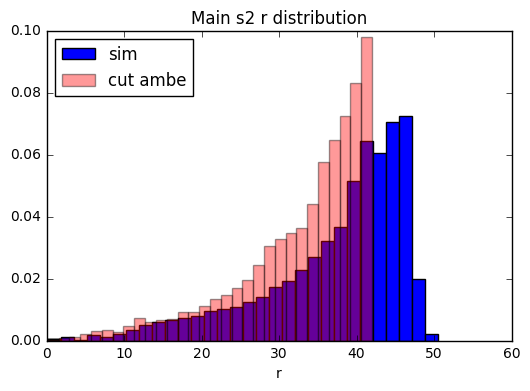

In [19]:
plt.hist(sim.r.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe.r.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Main s2 r distribution')
plt.legend(loc = 'upper left')
plt.xlabel('r')
plt.show()

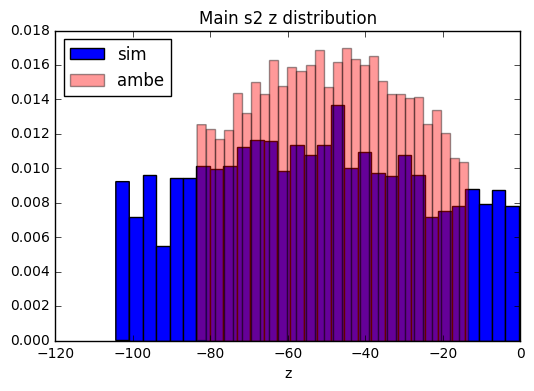

In [20]:
plt.hist(sim.z.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe.z.dropna(), bins=30,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Main s2 z distribution')
plt.legend(loc = 'upper left')
plt.xlabel('z')
plt.show()

I simulated directly from the ambe z distribution, so why would the simulation extend to -90??

## Largest other s2

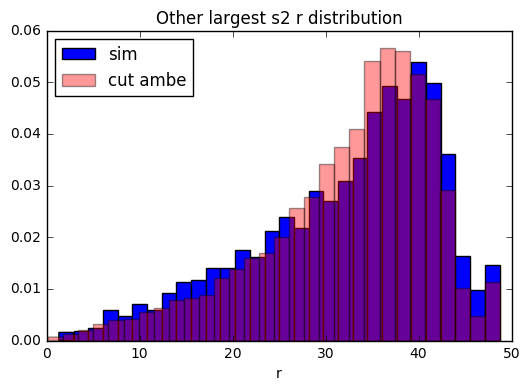

In [21]:
plt.hist(sim.s2_1_r.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe.s2_1_r.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Other largest s2 r distribution')
plt.legend(loc = 'upper left')
plt.xlabel('r')
plt.show()

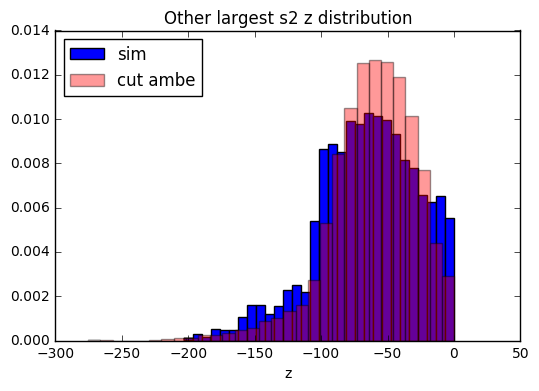

In [22]:
plt.hist(sim.s2_1_z.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe.s2_1_z.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Other largest s2 z distribution')
plt.legend(loc = 'upper left')
plt.xlabel('z')
plt.show()

# Distance between s2, largest other s2

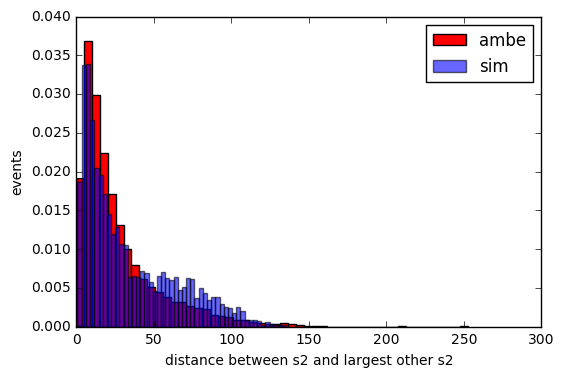

In [23]:
ambe['dist'] = np.sqrt((ambe.s2_1_x - ambe.x)**2 + 
                           (ambe.s2_1_y - ambe.y)**2 + 
                           (ambe.s2_1_z - ambe.z)**2 )

sim['dist'] = np.sqrt((sim.s2_1_x - sim.x)**2 + 
                           (sim.s2_1_y - sim.y)**2 + 
                           (sim.s2_1_z - sim.z)**2 )


plt.hist(ambe.dist.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.dist.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('distance between s2 and largest other s2')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

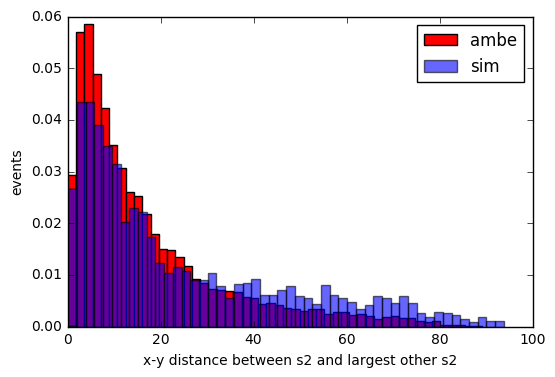

In [24]:
ambe['dist'] = np.sqrt((ambe.s2_1_x - ambe.x)**2 + 
                           (ambe.s2_1_y - ambe.y)**2 )

sim['dist'] = np.sqrt((sim.s2_1_x - sim.x)**2 + 
                           (sim.s2_1_y - sim.y)**2 )


plt.hist(ambe.dist.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.dist.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('x-y distance between s2 and largest other s2')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

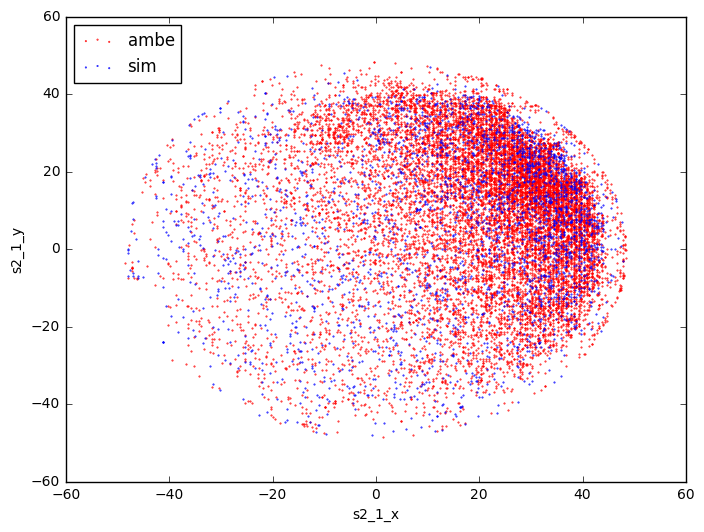

In [25]:
plot2d_compare('s2_1_x', 's2_1_y')

## Time delays

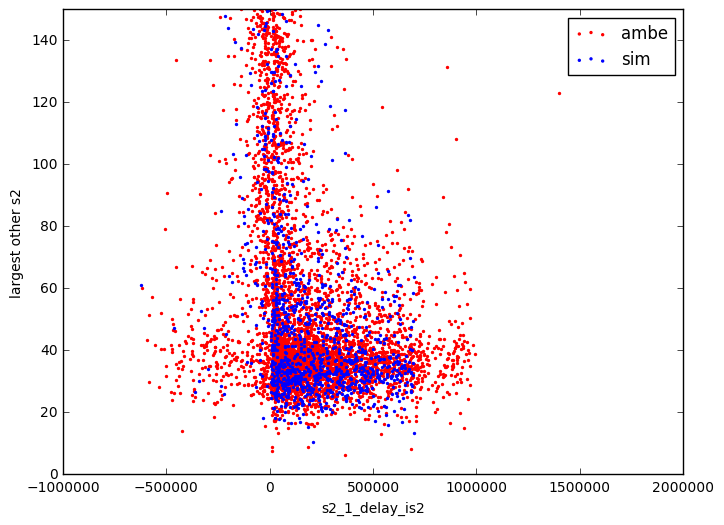

In [26]:
plt.figure(figsize = (8,6))
plt.scatter(ambe.s2_1_delay_is2, ambe.s2_1_area,label='ambe', color='r',s = 2)
plt.scatter(sim.s2_1_delay_is2, sim.s2_1_area, label='sim', color = 'b', s = 2)

plt.ylim(0,150)

plt.title('')
plt.xlabel('s2_1_delay_is2')
plt.ylabel('largest other s2')

plt.legend(loc = 'upper right')
plt.show()

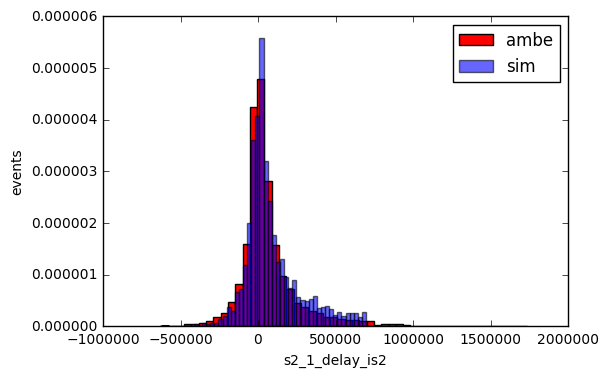

In [27]:
plt.hist(ambe.s2_1_delay_is2.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.s2_1_delay_is2.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('s2_1_delay_is2')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

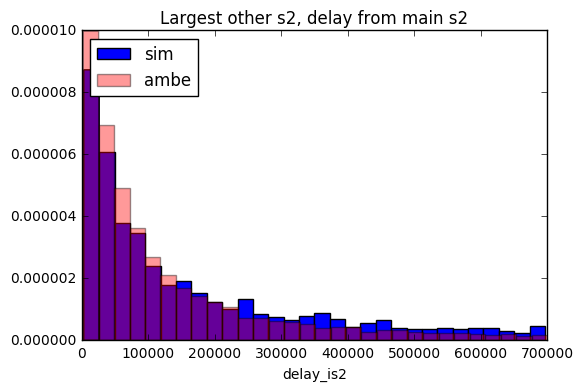

In [28]:
plt.hist(sim[(sim.s2_1_delay_is2 > -1000) & (sim.s2_1_delay_is2 < 700000)].s2_1_delay_is2.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe[(ambe.s2_1_delay_is2 > -1000) & (ambe.s2_1_delay_is2 < 700000)].s2_1_delay_is2.dropna(), bins=30,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Largest other s2, delay from main s2')
plt.legend(loc = 'upper left')
plt.xlabel('delay_is2')
plt.show()

In [29]:
bins = np.linspace(0,700000,10)
ambe_delay_area = slicing(ambe, 's2_1_delay_is2', 's2_1_area', bins)
sim_delay_area = slicing(sim, 's2_1_delay_is2', 's2_1_area', bins)

### Looking between 0 and 700,000 delay from main s2

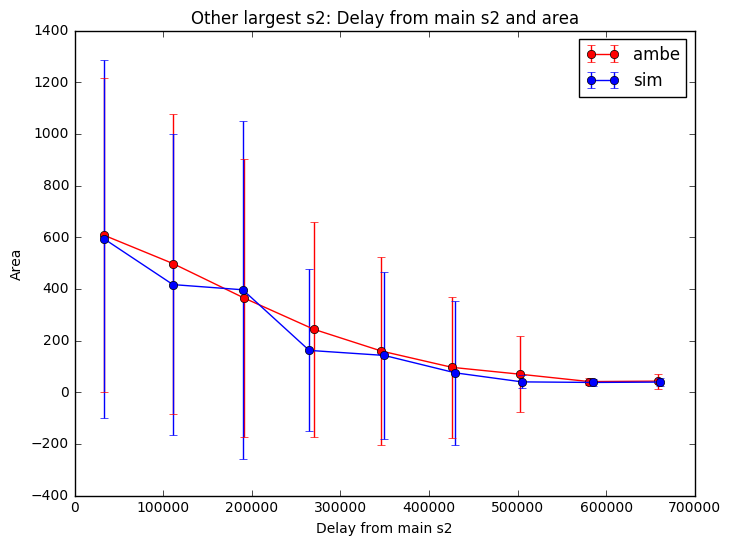

In [30]:
plt.figure(figsize=(8,6))
plt.errorbar(ambe_delay_area.s2_1_delay_is2, ambe_delay_area.s2_1_area, ambe_delay_area.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(sim_delay_area.s2_1_delay_is2, sim_delay_area.s2_1_area, sim_delay_area.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('Delay from main s2')
plt.ylabel('Area')


plt.title('Other largest s2: Delay from main s2 and area')

plt.legend(loc='upperright')
plt.show()

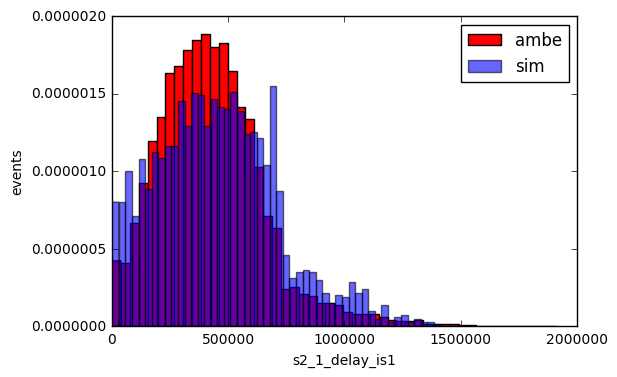

In [31]:
plt.hist(ambe.s2_1_delay_is1.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.s2_1_delay_is1.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('s2_1_delay_is1')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

In [32]:
print('ambe mean:' , np.mean(ambe.s2_1_delay_is1.dropna()))
print('ambe std:' , np.std(ambe.s2_1_delay_is1.dropna()))
print('sim mean:' , np.mean(sim.s2_1_delay_is1.dropna()))
print('sim std:' , np.std(sim.s2_1_delay_is1.dropna()))

ambe mean: 426191.767248
ambe std: 226489.524028
sim mean: 456908.669391
sim std: 262235.820512


# S2 - Largest other S2

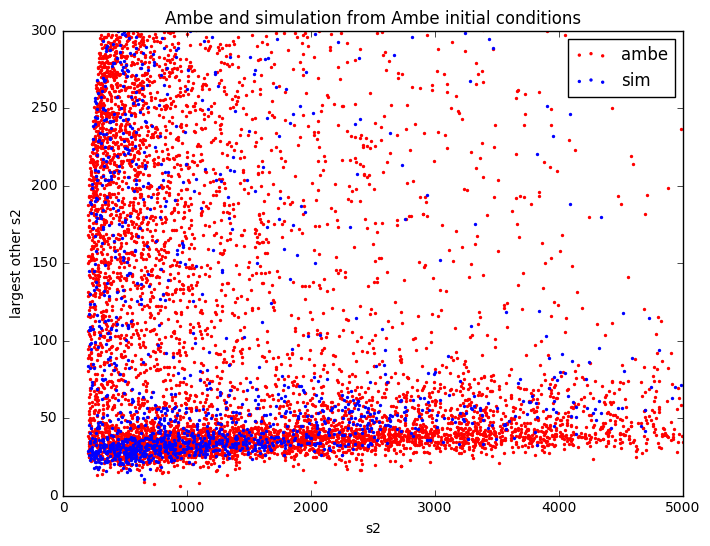

In [33]:
plt.figure(figsize = (8,6))
plt.scatter(ambe.s2, ambe.s2_1_area,label='ambe', color='r',s = 2)
plt.scatter(sim.s2, sim.s2_1_area, label='sim', color = 'b', s = 2)
plt.xlim(0,5000)
plt.ylim(0,300)
plt.title('Ambe and simulation from Ambe initial conditions')
plt.xlabel('s2')
plt.ylabel('largest other s2')

plt.legend(loc = 'upper right')
plt.show()

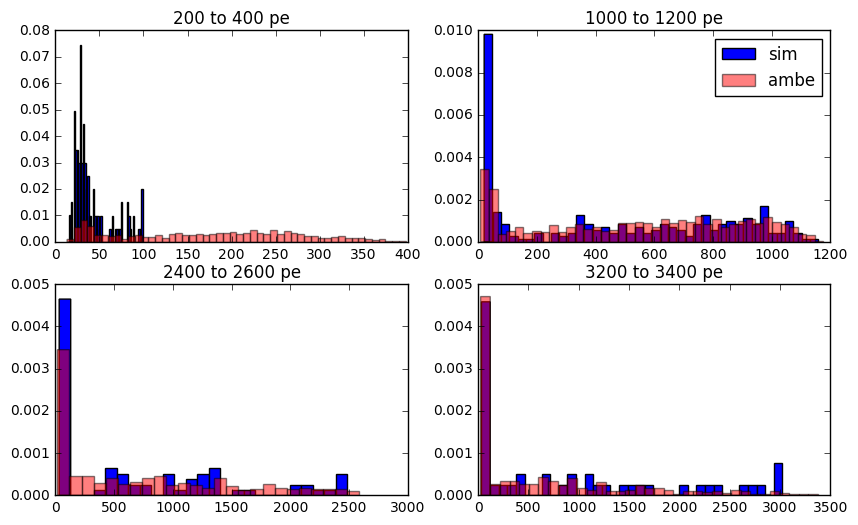

In [34]:
fig = plt.figure(figsize=(10,6))

plot_ranges = [[200,400],[1000,1200],[2400,2600],[3200,3400]]


df_1 = sim
df_2 = ambe

# ----------------------------------------
ax = fig.add_subplot(221)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[0][0]) & (df_1.s2 < plot_ranges[0][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[0][0]) & (df_2.s2 < plot_ranges[0][1])]

slice_df_1 = line_cut(slice_df_1, 's2_1_area', '<', 100)

ax.hist(slice_df_1.s2_1_area.dropna(), bins=50, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=50, color='r', alpha=0.5, label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[0][0], plot_ranges[0][1]))

# ----------------------------------------
ax = fig.add_subplot(222)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[1][0]) & (df_1.s2 < plot_ranges[1][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[1][0]) & (df_2.s2 < plot_ranges[1][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=40, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=40, color='r', alpha=0.5,  label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[1][0], plot_ranges[1][1]))

ax.legend(loc = 'upper right')

# ----------------------------------------
ax = fig.add_subplot(223)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[2][0]) & (df_1.s2 < plot_ranges[2][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[2][0]) & (df_2.s2 < plot_ranges[2][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=25, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=25, color='r', alpha=0.5,  label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[2][0], plot_ranges[2][1]))

# ----------------------------------------
ax = fig.add_subplot(224)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[3][0]) & (df_1.s2 < plot_ranges[3][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[3][0]) & (df_2.s2 < plot_ranges[3][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=35, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=35, color='r', alpha=0.5, label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[3][0], plot_ranges[3][1]))
    
plt.show()

In [35]:
bins = np.linspace(200,5000,20)
ambe_s2_and_other = slicing(ambe, 's2', 's2_1_area', bins)
sim_s2_and_other = slicing(sim, 's2', 's2_1_area', bins)

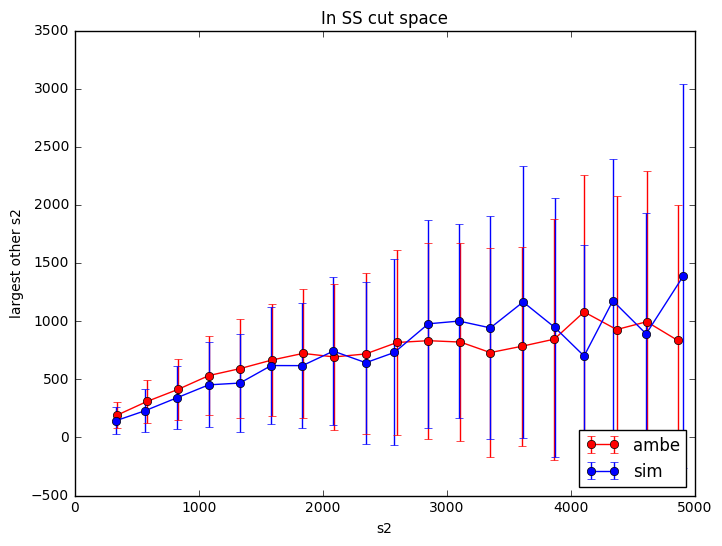

In [36]:
plt.figure(figsize=(8,6))
plt.errorbar(ambe_s2_and_other.s2, ambe_s2_and_other.s2_1_area, ambe_s2_and_other.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(sim_s2_and_other.s2, sim_s2_and_other.s2_1_area, sim_s2_and_other.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('s2')
plt.ylabel('largest other s2')

plt.title('In SS cut space')

plt.legend(loc='lower right')
plt.show()

# Diffusion

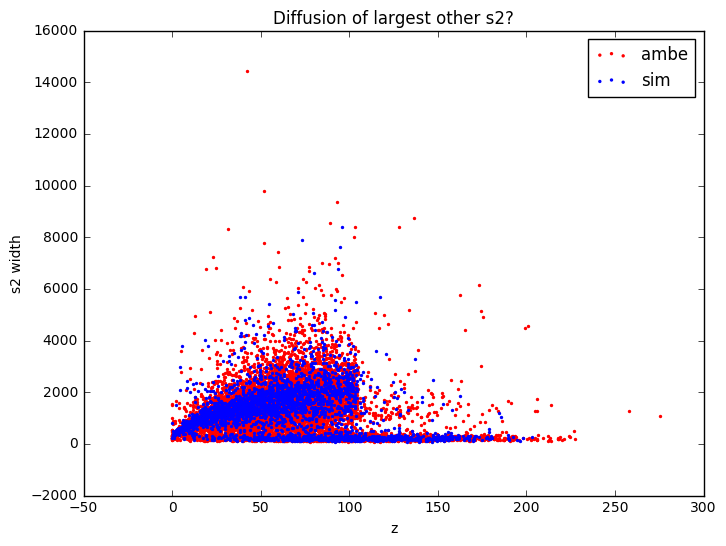

In [37]:
plt.figure(figsize = (8,6))
plt.scatter(-ambe.s2_1_z, ambe.s2_1_range_50p_area,label='ambe', color='r',s = 2)
plt.scatter(-sim.s2_1_z, sim.s2_1_range_50p_area,label='sim',color = 'b',s = 2)

plt.title('Diffusion of largest other s2?')
plt.xlabel('z')
plt.ylabel('s2 width')

plt.legend(loc = 'upper right')
plt.show()

Why is simulation displaced down in the detector? z is determined via the drift time and electron lifetime. is it offset?

# Electron Lifetime

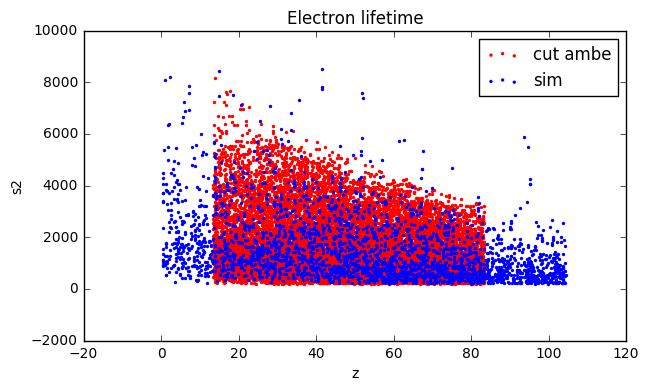

In [38]:
plt.figure(figsize = (7,4))
plt.scatter(-ambe.z, ambe.s2,label='cut ambe', color='r',s = 2)
plt.scatter(-sim.z, sim.s2,label='sim',color = 'b',s = 2)

plt.title('Electron lifetime')
plt.xlabel('z')
plt.ylabel('s2')

plt.legend(loc = 'upper right')
plt.show()

lifetime (us):706.90696284945204
+/-8.7773915607779266e-05


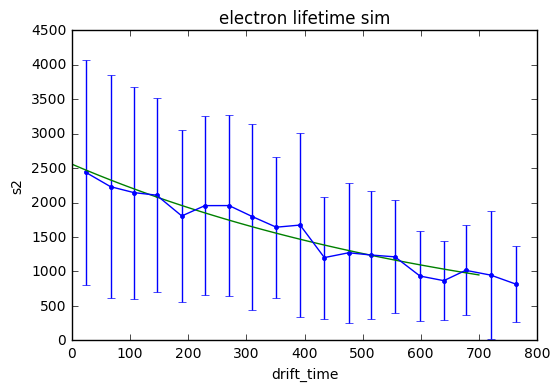

In [39]:
from scipy.optimize import curve_fit

def exp_func(x,a,b):
	return a*np.exp(-b*x)

sim['drift_time'] = sim['z'] / (1.335 * 0.1)
ambe['drift_time'] = ambe['z'] / (1.335 * 0.1)

##############################################
d1 = sim
d1.drift_time = abs(d1.drift_time)
minz = min(d1.drift_time)
maxz = max(d1.drift_time)

bins = np.linspace(minz, maxz, 20)

ds = slicing(d1, 'drift_time', 's2', bins)

popt, pcov = curve_fit(exp_func, ds.drift_time, ds.s2, p0 = (5000,1e-5))

xx = np.linspace(0,700,100)
yy = exp_func(xx, *popt)

plt.plot(ds.drift_time, ds.s2,'.',xx,yy,'-')

plt.errorbar(ds.drift_time, ds.s2, yerr = ds.sigma,color='b')

plt.title('electron lifetime sim')
plt.xlabel('drift_time')
plt.ylabel('s2')

print('lifetime (us):' + repr( 1/popt[1]))
print('+/-' + repr(np.sqrt(pcov[1,1])))

plt.show()

lifetime (us):721.89422469660838
+/-6.1285101246458042e-05


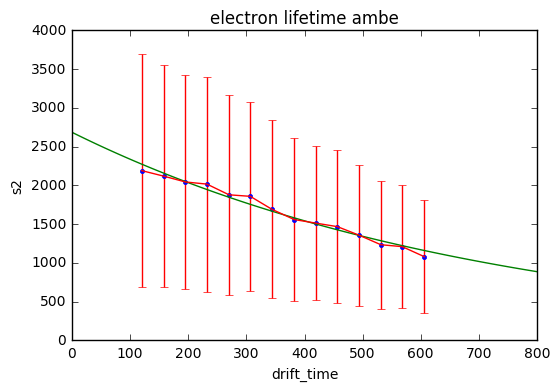

In [40]:
##############################################
d1 = ambe
d1.drift_time = abs(d1.drift_time)
minz = min(d1.drift_time)
maxz = max(d1.drift_time)

bins = np.linspace(minz, maxz, 15)

ds = slicing(d1, 'drift_time', 's2', bins)

popt, pcov = curve_fit(exp_func, ds.drift_time, ds.s2, p0 = (5000,1e-5))

xx = np.linspace(0,800,100)
yy = exp_func(xx, *popt)

plt.plot(ds.drift_time,ds.s2,'.',xx,yy,'-')

plt.errorbar(ds.drift_time, ds.s2, yerr = ds.sigma,color='r')

plt.title('electron lifetime ambe')
plt.xlabel('drift_time')
plt.ylabel('s2')

print('lifetime (us):' + repr( 1/popt[1]))
print('+/-' + repr(np.sqrt(pcov[1,1])))

plt.show()

# Area, goodness of fit

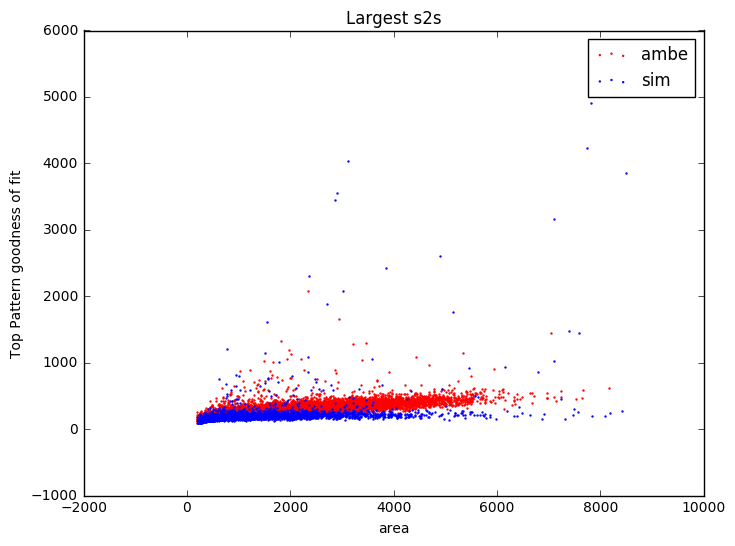

In [41]:
plt.figure(figsize = (8,6))

plt.scatter(ambe.s2, ambe.s2_pattern_fit,label='ambe',color = 'r',s = 0.5)

plt.scatter(sim.s2, sim.goodness_of_fit,label='sim',color = 'b',s = 0.5)
def area_cut(area):
    return 15*(area - 10)**.45

x = np.linspace(0,300,100)

plt.title('Largest s2s')
plt.xlabel('area')
plt.ylabel('Top Pattern goodness of fit')

# plt.plot(x, area_cut(x),color = 'g')

plt.legend(loc = 'upper right')
plt.show()

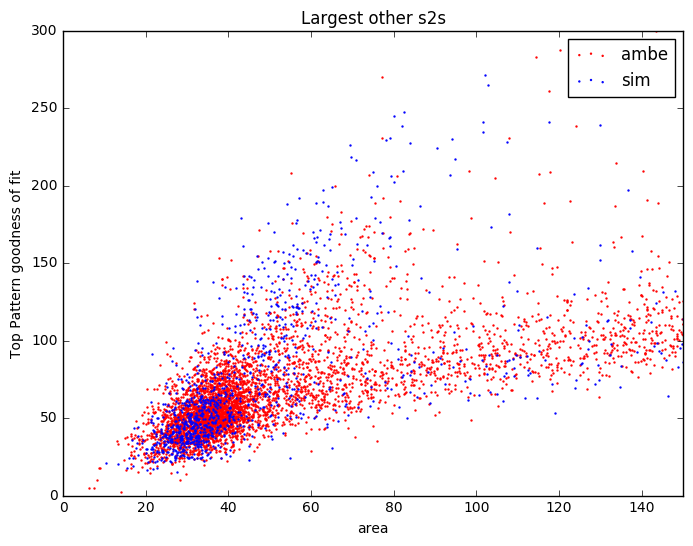

In [42]:
plt.figure(figsize = (8,6))

plt.scatter(ambe.s2_1_area, ambe.s2_1_goodness_of_fit,label='ambe',color = 'r',s = 0.5)

plt.scatter(sim.s2_1_area, sim.s2_1_goodness_of_fit,label='sim',color = 'b',s = 0.5)
def area_cut(area):
    return 15*(area - 10)**.45

x = np.linspace(0,300,100)

plt.xlim(0,150)
plt.ylim(0,300)
plt.title('Largest other s2s')
plt.xlabel('area')
plt.ylabel('Top Pattern goodness of fit')

# plt.plot(x, area_cut(x),color = 'g')

plt.legend(loc = 'upper right')
plt.show()

### GoF comparisons

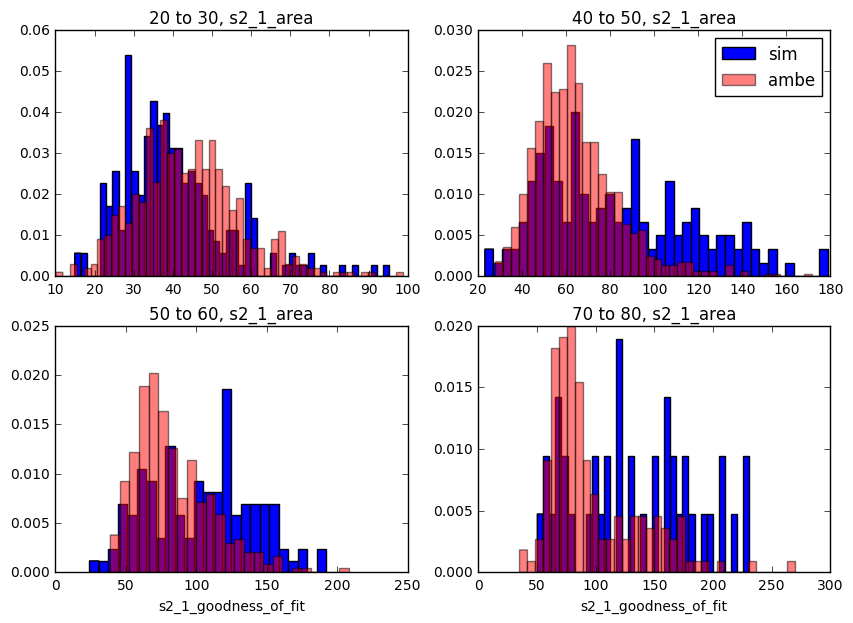

In [43]:
fig = plt.figure(figsize=(10,6))

plot_ranges = [[20,30],[40,50],[50,60],[70,80]]

four_hist_compare(sim, ambe, 's2_1_area', 's2_1_goodness_of_fit', plot_ranges)

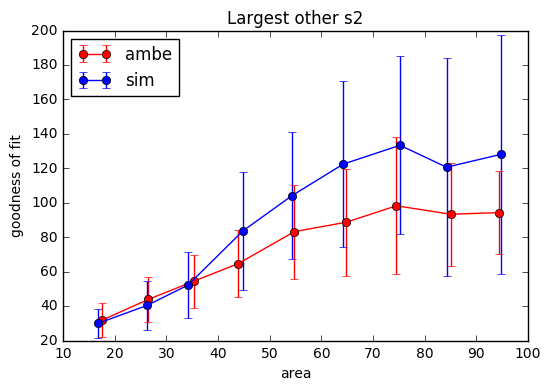

In [44]:
gof_bins = np.linspace(10,100,10)

gof_ambe = slicing(ambe, 's2_1_area', 's2_1_goodness_of_fit', gof_bins)
gof_sim = slicing(sim, 's2_1_area', 's2_1_goodness_of_fit', gof_bins)

plt.errorbar(gof_ambe.s2_1_area, gof_ambe.s2_1_goodness_of_fit, gof_ambe.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(gof_sim.s2_1_area, gof_sim.s2_1_goodness_of_fit, gof_sim.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('area')
plt.ylabel('goodness of fit')

plt.title('Largest other s2')

plt.legend(loc='upper left')
plt.show()